Using device: cuda


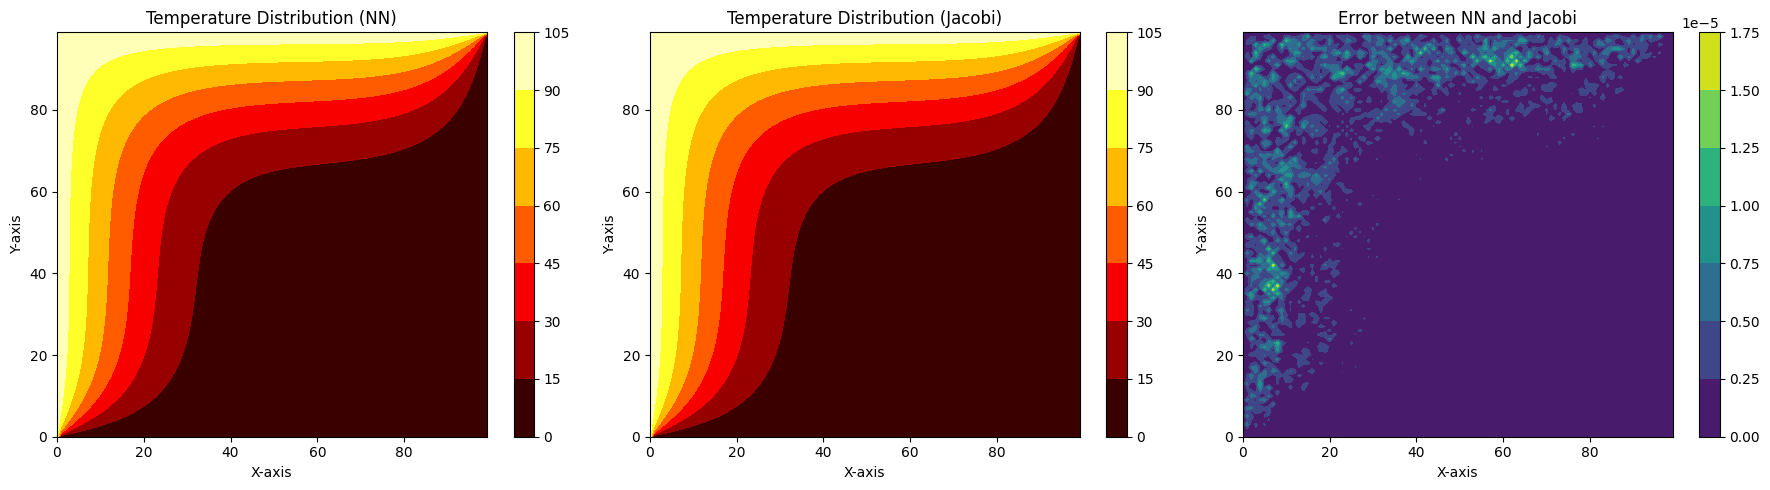

Time taken for NN approach: 0.45535850524902344 seconds
Time taken for Jacobi method: 7.490741729736328 seconds


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Parameters
m, n = 100, 100  # Grid sizex
num_iterations = 1000

# Initialize the temperature grid for neural network-based approach
T = torch.zeros(m * n, requires_grad=False, device=device)

# Boundary conditions
left_BC = 100
bottom_BC = 100

# Apply boundary conditions initially
T = T.reshape(m, n)
T[:, 0] = left_BC  # Apply left boundary condition
T[-1, :] = bottom_BC  # Apply bottom boundary condition
T = T.flatten()

# Create the weight matrix for the Jacobi method
weight = torch.zeros(m * n, m * n, device=device)

# Fill the weight matrix according to the Jacobi stencil operation
for i in range(m):
    for j in range(n):
        index = i * n + j
        if not (i == 0 or i == m-1 or j == 0 or j == n-1):  # Skip boundary nodes
            if i > 0:  # T_{i-1,j}
                weight[index, (i - 1) * n + j] = 1/4
            if i < m - 1:  # T_{i+1,j}
                weight[index, (i + 1) * n + j] = 1/4
            if j > 0:  # T_{i,j-1}
                weight[index, i * n + (j - 1)] = 1/4
            if j < n - 1:  # T_{i,j+1}
                weight[index, i * n + (j + 1)] = 1/4

# Define the custom sparse linear layer with fixed weights
class SparseLinearLayer(nn.Module):
    def __init__(self, weight):
        super(SparseLinearLayer, self).__init__()
        self.weight = nn.Parameter(weight, requires_grad=False)
        
    def forward(self, T):
        T_new = torch.matmul(self.weight, T)
        return T_new

# Initialize the sparse linear layer with the weight matrix
sparse_layer = SparseLinearLayer(weight).to(device)

# Timer for neural network-based approach
start_time_nn = time.time()

# Iterative solver for neural network-based approach
for _ in range(num_iterations):
    T_new = sparse_layer(T)
    T_new = T_new.reshape(m, n)
    T_new[:, 0] = left_BC  # Reapply left boundary condition
    T_new[-1, :] = bottom_BC  # Reapply bottom boundary condition
    T = T_new.flatten()

end_time_nn = time.time()

# Reshape back to 2D for visualization
T_nn = T.reshape(m, n).detach().cpu().numpy()

# Timer for Jacobi method
start_time_jacobi = time.time()

# Initialize the temperature grid for Jacobi method
T_jacobi = np.zeros((m, n))

# Apply boundary conditions
T_jacobi[:, 0] = left_BC
T_jacobi[-1, :] = bottom_BC

# Jacobi iterative solver
for _ in range(num_iterations):
    T_new = T_jacobi.copy()
    for i in range(1, m-1):
        for j in range(1, n-1):
            T_new[i, j] = 0.25 * (T_jacobi[i-1, j] + T_jacobi[i+1, j] + T_jacobi[i, j-1] + T_jacobi[i, j+1])
    T_jacobi = T_new
    
    # Reapply boundary conditions
    T_jacobi[:, 0] = left_BC
    T_jacobi[-1, :] = bottom_BC

end_time_jacobi = time.time()

# Calculate error between the two methods
error = np.abs(T_nn - T_jacobi)

# Plotting the temperature distributions and error
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Neural network-based approach
c1 = ax[0].contourf(T_nn, cmap='hot')
fig.colorbar(c1, ax=ax[0])
ax[0].set_title('Temperature Distribution (NN)')
ax[0].set_xlabel('X-axis')
ax[0].set_ylabel('Y-axis')

# Jacobi method
c2 = ax[1].contourf(T_jacobi, cmap='hot')
fig.colorbar(c2, ax=ax[1])
ax[1].set_title('Temperature Distribution (Jacobi)')
ax[1].set_xlabel('X-axis')
ax[1].set_ylabel('Y-axis')

# Error plot
c3 = ax[2].contourf(error, cmap='viridis')
fig.colorbar(c3, ax=ax[2])
ax[2].set_title('Error between NN and Jacobi')
ax[2].set_xlabel('X-axis')
ax[2].set_ylabel('Y-axis')

plt.tight_layout()
plt.show()

# Print timing information
print(f"Time taken for NN approach: {end_time_nn - start_time_nn} seconds")
print(f"Time taken for Jacobi method: {end_time_jacobi - start_time_jacobi} seconds")


Using device: cuda


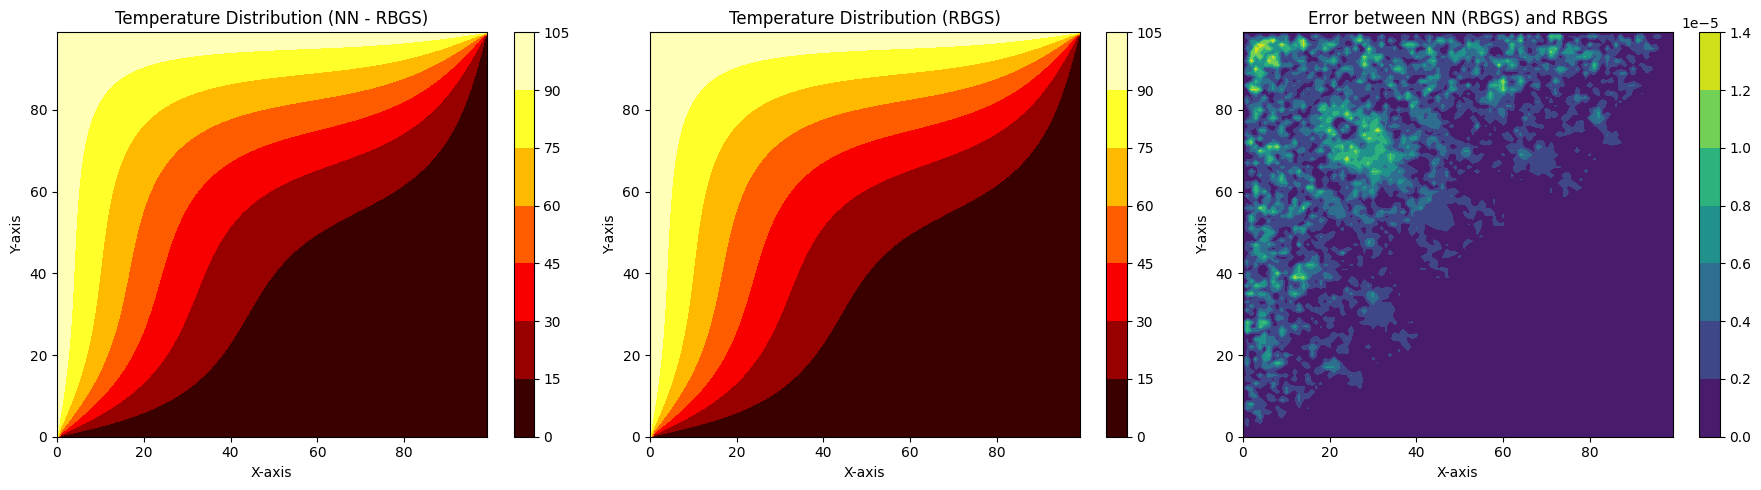

Time taken for NN approach (RBGS): 0.6463277339935303 seconds
Time taken for RBGS method: 8.820300579071045 seconds


In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Parameters
# Parameters
m, n = 100, 100  # Grid size
num_iterations = 1000

# Device configuration (use 'cuda' if GPU is available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the temperature grid
T_nn = torch.zeros(m * n, requires_grad=False, device=device)

# Boundary conditions
left_BC = 100
bottom_BC = 100

# Apply boundary conditions initially
T_nn = T_nn.reshape(m, n)
T_nn[:, 0] = left_BC  # Apply left boundary condition
T_nn[-1, :] = bottom_BC  # Apply bottom boundary condition
T_nn = T_nn.flatten()

# Create the weight matrices for Red-Black Gauss-Seidel (RBGS)
weight_red = torch.zeros(m * n, m * n, device=device)
weight_black = torch.zeros(m * n, m * n, device=device)

# Fill the weight matrices according to RBGS stencil operation
for i in range(m):
    for j in range(n):
        index = i * n + j
        if not (i == 0 or i == m-1 or j == 0 or j == n-1):  # Skip boundary nodes
            if (i + j) % 2 == 0:  # Red points
                if i > 0:  # T_{i-1,j}
                    weight_red[index, (i - 1) * n + j] = 0.25
                if i < m - 1:  # T_{i+1,j}
                    weight_red[index, (i + 1) * n + j] = 0.25
                if j > 0:  # T_{i,j-1}
                    weight_red[index, i * n + (j - 1)] = 0.25
                if j < n - 1:  # T_{i,j+1}
                    weight_red[index, i * n + (j + 1)] = 0.25
                weight_black[index,index] = 1
            else:  # Black points
                if i > 0:  # T_{i-1,j}
                    weight_black[index, (i - 1) * n + j] = 0.25
                if i < m - 1:  # T_{i+1,j}
                    weight_black[index, (i + 1) * n + j] = 0.25
                if j > 0:  # T_{i,j-1}
                    weight_black[index, i * n + (j - 1)] = 0.25
                if j < n - 1:  # T_{i,j+1}
                    weight_black[index, i * n + (j + 1)] = 0.25
        else:
            weight_red[index, index] = 1
            weight_red[index, index] = 1
            weight_red[index, index] = 1
            weight_red[index, index] = 1
            weight_black[index, index] = 1
            weight_black[index, index] = 1
            weight_black[index, index] = 1
            weight_black[index, index] = 1


# Define the custom RBGS linear layer with alternating weights
class RBGSLayer(nn.Module):
    def __init__(self, weight_red, weight_black):
        super(RBGSLayer, self).__init__()
        self.weight_red = nn.Parameter(weight_red, requires_grad=False)
        self.weight_black = nn.Parameter(weight_black, requires_grad=False)
        
    def forward(self, T):
        T = torch.matmul(self.weight_red, T)
        T = torch.matmul(self.weight_black, T)
        return T

# Initialize the RBGS linear layer
rbgs_layer = RBGSLayer(weight_red, weight_black).to(device)

# Timer for neural network-based approach
start_time_nn = time.time()

# Iterative solver for neural network-based approach (RBGS-inspired)
for _ in range(num_iterations):
    T_nn = rbgs_layer(T_nn)


end_time_nn = time.time()

# Reshape back to 2D for visualization
T_nn = T_nn.reshape(m, n).detach().cpu().numpy()

# Initialize the temperature grid for Red-Black Gauss-Seidel (RBGS) method
T_rbgs = np.zeros((m, n))

# Apply boundary conditions
T_rbgs[:, 0] = left_BC
T_rbgs[-1, :] = bottom_BC

# Timer for RBGS method
start_time_rbgs = time.time()

# Red-Black Gauss-Seidel (RBGS) iterative solver
for _ in range(num_iterations):
    # Red points update
    for i in range(1, m-1):
        for j in range(1, n-1):
            if (i + j) % 2 == 0:
                T_rbgs[i, j] = 0.25 * (T_rbgs[i-1, j] + T_rbgs[i+1, j] + T_rbgs[i, j-1] + T_rbgs[i, j+1])
                
    # Black points update
    for i in range(1, m-1):
        for j in range(1, n-1):
            if (i + j) % 2 == 1:
                T_rbgs[i, j] = 0.25 * (T_rbgs[i-1, j] + T_rbgs[i+1, j] + T_rbgs[i, j-1] + T_rbgs[i, j+1])

    # Reapply boundary conditions (only once after each complete iteration)
    # T_rbgs[:, 0] = left_BC
    # T_rbgs[-1, :] = bottom_BC

end_time_rbgs = time.time()

# Calculate error between the two methods
error = np.abs(T_nn - T_rbgs)

# Plotting the temperature distributions and error
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Neural network-based approach (RBGS-inspired)
c1 = ax[0].contourf(T_nn, cmap='hot')
fig.colorbar(c1, ax=ax[0])
ax[0].set_title('Temperature Distribution (NN - RBGS)')
ax[0].set_xlabel('X-axis')
ax[0].set_ylabel('Y-axis')

# RBGS method
c2 = ax[1].contourf(T_rbgs, cmap='hot')
fig.colorbar(c2, ax=ax[1])
ax[1].set_title('Temperature Distribution (RBGS)')
ax[1].set_xlabel('X-axis')
ax[1].set_ylabel('Y-axis')

# Error plot
c3 = ax[2].contourf(error, cmap='viridis')
fig.colorbar(c3, ax=ax[2])
ax[2].set_title('Error between NN (RBGS) and RBGS')
ax[2].set_xlabel('X-axis')
ax[2].set_ylabel('Y-axis')

plt.tight_layout()
plt.show()

# Print timing information
print(f"Time taken for NN approach (RBGS): {end_time_nn - start_time_nn} seconds")
print(f"Time taken for RBGS method: {end_time_rbgs - start_time_rbgs} seconds")


Initial grid:


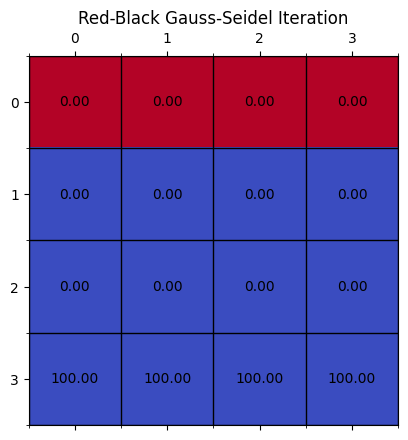

Iteration 1:


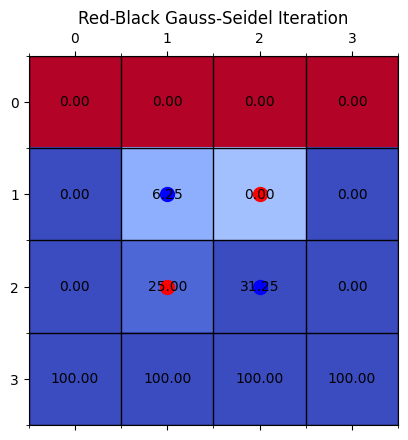

Iteration 2:


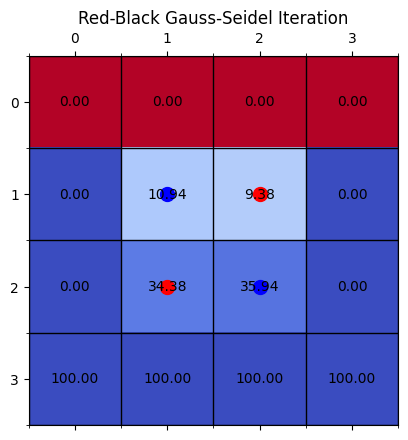

Iteration 3:


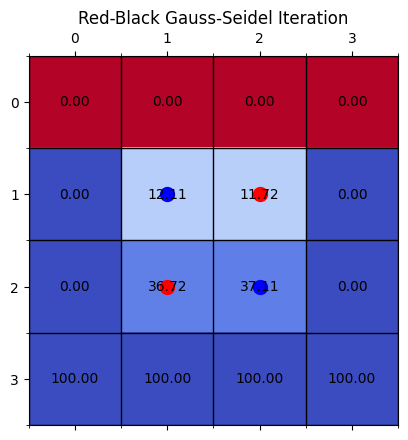

Iteration 4:


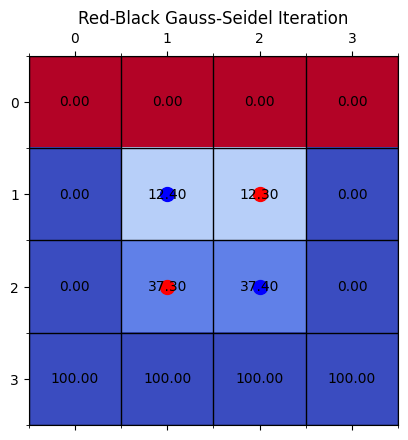

Iteration 5:


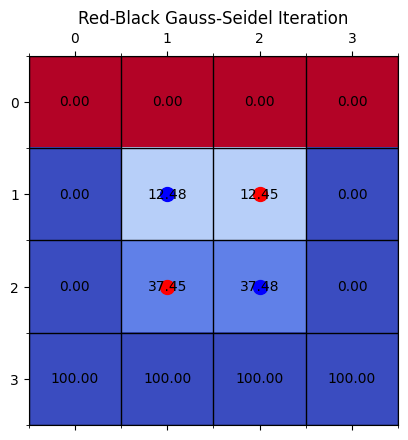

[(1, 1), (2, 2)]
[(1, 2), (2, 1)]


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_grid_with_operations(T, red_points, black_points):
    Nx, Ny = T.shape
    fig, ax = plt.subplots()
    
    # Plot red and black points
    for i, j in red_points:
        ax.plot(j, Nx - i - 1, 'ro', markersize=10)
    for i, j in black_points:
        ax.plot(j, Nx - i - 1, 'bo', markersize=10)
    
    # Plot grid and annotate temperatures
    ax.matshow(T, cmap='coolwarm')
    for i in range(Nx):
        for j in range(Ny):
            ax.text(j, Nx - i - 1, f'{T[i, j]:.2f}', va='center', ha='center', color='black')
    
    ax.set_xticks(np.arange(-0.5, Ny, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, Nx, 1), minor=True)
    ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
    
    plt.title('Red-Black Gauss-Seidel Iteration')
    plt.show()

# Initialize a 4x4 grid (including boundary conditions)
T = np.zeros((4, 4))
T[0, :] = 100  # Example boundary condition: top row
T[-1, :] = 0   # Example boundary condition: bottom row

# Visualize the initial grid
print("Initial grid:")
plot_grid_with_operations(T, [], [])

# Perform a few iterations of Red-Black Gauss-Seidel
max_iter = 5
for iteration in range(max_iter):
    red_points = []
    black_points = []
    
    # Red points update (excluding boundaries)
    for i in range(1, 3):
        for j in range(1, 3):
            if (i + j) % 2 == 0:  # red point
                T[i, j] = 0.25 * (T[i-1, j] + T[i+1, j] + T[i, j-1] + T[i, j+1])
                red_points.append((i, j))
    
    # Black points update (excluding boundaries)
    for i in range(1, 3):
        for j in range(1, 3):
            if (i + j) % 2 == 1:  # black point
                T[i, j] = 0.25 * (T[i-1, j] + T[i+1, j] + T[i, j-1] + T[i, j+1])
                black_points.append((i, j))
    
    # Visualize the updated grid after each iteration
    print(f"Iteration {iteration + 1}:")
    plot_grid_with_operations(T, red_points, black_points)

print(red_points)
print(black_points)
